In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33

# path = "eos_data/nl3cr_short.csv" # Trimmed ~50 lines
# path = "eos_data/sly230a_short.csv" # No difference from sly230a
# path = "eos_data/sly_short.csv" # Trimmed ~30 lines
path = "eos_data/sly230a.csv"
# path = "eos_data/sly.csv" 
# path = "eos_data/nl3cr.csv" 

# DIMENSIONS CHECKED
def lamba_metric(M, R):
    # Removed factor of 2 since the paper didnt implement it. 
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

## EOS DATA ###
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), kind = "cubic", bounds_error=True)
#     f_e_smooth = interp1d(p, e, fill_value= "extrapolate", kind = "cubic")
    return f_e_smooth

# def get_ep(e, p):
#     f_e_smooth = interp1d(p, e, fill_value = "extrapolate", kind = "cubic")
#     return f_e_smooth

def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
#     f_e_smooth = interp1d(e, p, fill_value="extrapolate", kind = "cubic")
    return f_e_smooth

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _b(r, M):
    return (G*M)/((c**2)*r)

# DIMENSIONS CHECKED
def _dvdr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q

# DIMENSIONS CHECKED
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [5]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dWdr(r, W, U, Q, lamda, l, omega, v, c_ad2):
    term1 = -1*(l+1)*( W - l * np.exp(v + lamda/2) * U)
    frac = -1 * ((omega*r)**2) * (np.exp(lamda/2)/(c_ad2))
    term2 = frac * (U - np.exp(lamda/2)*Q*W*(c**2)/((omega*r)**2))
    dWdlnr = term1 + term2
    dWdr = 1/r * dWdlnr
    return dWdr

# DIMENSIONS CHECKED
def _dUdr(r, W, U, lamda, l, v):
    dUdlnr = np.exp(lamda/2 - v) * (W - l*(np.exp(v-lamda/2))*U)
    dUdr = 1/r * dUdlnr
    return dUdr

In [6]:
# def _dWdr(r, V, W, phi, dphidr, drhodp, omega, lamda, l):
#     term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V
#     term2 = dphidr * W * (c**2)
#     brackets = term1 + term2
#     ret = (drhodp * brackets) - l*(l+1)*np.exp(lamda)*V
#     return ret

# # DIMENSIONS CHECKED
# def _dUdr(r, V, W, dphidr, lamda):
#     return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

In [7]:
def e_func(P, p_0 = 1.67e14 * (c**2), K = 0.0195, gamma = 2.34):
    ret = (p_0 * ((P)/(K*p_0)) ** (1/gamma) + P/(gamma - 1)) 
    return ret 

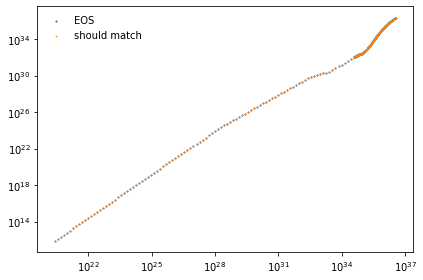

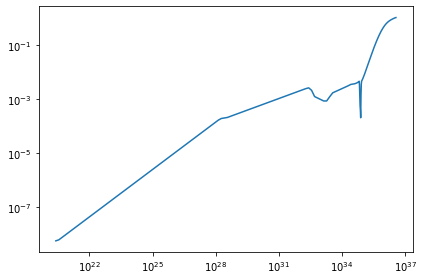

In [8]:
df = pd.read_csv(path)
e_old, p_old = df_to_ep(df)

# p = p_old
# e = e_func(p)

### EOS DATA ###
p = p_old
e = e_old
 
p_min = min(p)
p_max = max(p)
EOS = get_ep(e, p)
EOS_inv = get_pe(p, e)
plt.scatter(e_old, p_old, s = 1, label = "EOS")
plt.xscale("log")
plt.yscale("log")

### EOS DATA ###
def dPde_helper(p, e):
    _p = get_pe(p, e)
    e_min = np.log10(min(e))
    e_max = np.log10(max(e))
    e_arr = np.logspace(e_min+1e-8, e_max, int(1e4), endpoint = False)
    ret = np.gradient(_p(e_arr), e_arr, edge_order=1)
#     return ret, e_arr
    return np.gradient(p, e), e

def dPde(p, e):
    dpde_helper, e_arr = dPde_helper(p, e)
#     return interp1d(e_arr, dpde_helper, fill_value=(0, 0), bounds_error=True, kind = "cubic")
    return interp1d(e_arr, dpde_helper, fill_value="extrapolate", kind = "cubic")

dpde = dPde(p, e)

def dPdrho(e, dpde = dpde):
    return c**2 * dpde(e)

plt.scatter(e, EOS_inv(e), s = 0.5, label = "should match")
plt.legend()

plt.figure()
plt.plot(e, dpde(e))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [9]:
# EOS_inv(n_den)
# dpde(e)
# np.percentile(p, 20)

In [10]:
from scipy.misc import derivative 

def coupledTOV(r, VEC, init_params):
    P, M, v, W, U = VEC
    EOS, l, omeg = init_params
    lamda = np.log(1/(1-2*_b(r, M)))
    Q = _Q(r, P, M) 

    if P < p_min: 
        return None
    
    if P > p_max:
        return None
    
    e = EOS(P)
    dpdrho = dPdrho(e)
    c_ad2 = dpdrho 
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, Q, lamda)
    dWdr = _dWdr(r, W, U, Q, lamda, l, omega, v, c_ad2)
    dUdr = _dUdr(r, W, U, lamda, l, v)

#     drhodp = 1/c_ad2
#     dphidr = 0.5 * dvdr
#     phi = 0.5 * v
#     dWdr = _dWdr(r, U, W, phi, dphidr, drhodp, omega, lamda, l)
#     dUdr = _dUdr(r, U, W, dphidr, lamda)
    
    ret = [dPdr, dMdr, dvdr, dWdr, dUdr]
    return ret

In [11]:
def tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
        l=2, n_iter_max = 2000):
    
    init_params = [EOS, l, omega]

    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] > p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)

        if progress:
            pbar.update(1)
            
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
            
        # Exit if pressure if less than minimum pressure
        if (r.y[0] < p_min):
            break
            
        results.append(integral)
        r_list.append(r.t+dr)
            
    print(r.successful(),(r.y[0] >= p_min)) # Used to find out which condition breaks 1st.    
    
    if progress:
        pbar.close()
    
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [12]:
# Load EOS
df = pd.read_csv(path)
e_old, p_old = df_to_ep(df)

# p = p_old
# e = e_func(p)

### EOS DATA ###
p = p_old
e = e_old

EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-40]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = EOS(p_c)
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3


omega = 2e3*(2*np.pi) #Arbitrary guess
l=2

v0 = -1 # Two step integration optimization: similar to phi previously.

W0 = 1
U0 = W0/(l * np.exp(v0))

dedp_EQ = None

init_VEC = [p_c, m0, v0, W0, U0]


# Integrate
p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                           omega, progress = True,l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
v_R = v[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(v_R)

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {interior:.8f}")
print(f"Exterior Surface: {schild:.8f}")
print(f"v0 Round 1: {v0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")

True False

== First Integration == 
Star has mass 1.033 Msun and radius 11.900km
Interior Surface: 0.50515584
Exterior Surface: 0.74373013
v0 Round 1: -1
Lamda Round 1: 0.29607704355691045


In [13]:
print(f"{p_min:.2f}")
p # Notice that the surface pressure is well above lower limit. 

813543308974.93


array([6.33244071e+34, 6.33240987e+34, 6.33235848e+34, ...,
       3.65723309e+24, 1.09249760e+24, 1.19374519e+23])

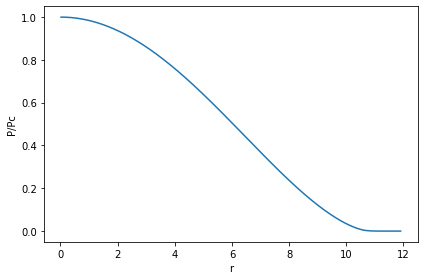

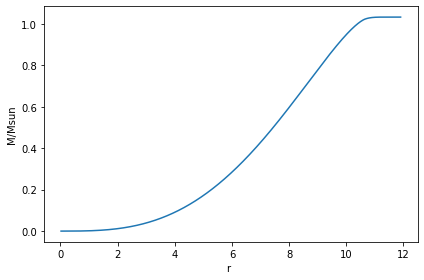

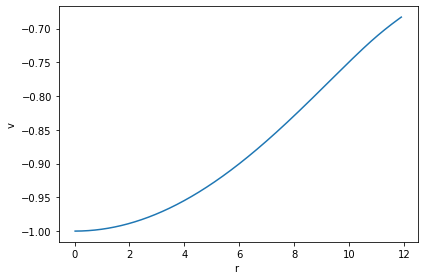

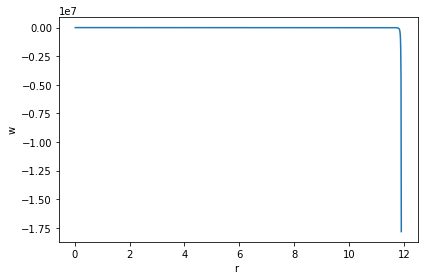

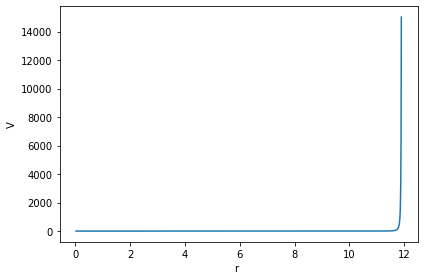

In [14]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -u*np.exp(v))
plt.xlabel("r ")
plt.ylabel("V")
plt.show()